In [2]:
import abc # class inheritance
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from auxiliary_functions import pandas_df_from_formula

# Base Model: Multivariate Linear Regression

Example Synthetic Data:

In [3]:
# Formula
formula = 'y ~ x1+x2+x3 + x2^3 + x3^4'

# Example Data
np.random.seed(33)
target = np.random.rand(500)
data = pd.DataFrame.from_dict(
    {'y': target, 
    'x1': target + np.random.rand(500) * 0.1, 
    'x2': np.sqrt(target), 
    'x3': np.random.rand(500)}
)
data.head()

,y,x1,x2,x3
0,0.248510,0.316099,0.498508,0.655227
1,0.449975,0.502719,0.670802,0.731060
2,0.410941,0.509836,0.641047,0.573652
3,0.260300,0.262202,0.510196,0.962793
4,0.870396,0.895319,0.932950,0.584785


The base model will be a multivariate linear regression one, but the method to update the coefficients (_update_coefficients) will change on the following implementations, depending on the regularization method used. The first model, however, will have no regularization, and will be the reference to appreciate the changes.

In [ ]:
class base_model(abc.ABC):
    def __init__(
            self, fit_intercept: bool = True, 
            iterations = 1000, seed = 33, learning_rate = 1e-3
    ):
        self.fit_intercept = fit_intercept
        self.iterations = iterations
        self.seed = seed
        self.lr = learning_rate

        # Coefficients
        self.b = None
        self.num_classes = None

        # Formula
        self.formula = None

        # Loss values (plot)
        self.loss = []

    # Internal calculations (Private Methods)
    def _separate_variables(self, formula: str, data: pd.DataFrame):
        """
        From a pandas Data Frame and a formula, extract the target variable 
        and the independent variables needed to train the model. Then, separate
        them in two Data Frames (y, X).
        """
        # Custom function to extract data from formula expression
        df = pandas_df_from_formula(formula, data)
        
        # This function always return the target variable as the first column
        return (df.iloc[:,0], df.iloc[:, 1:]) # (y, X)

    def _add_intercept(self, X: pd.DataFrame):
        """
        Add a column of ones as the first column of the X matrix.
        This guarantees that the last column of X will be a real variable.
        """
        intercept = np.ones((X.shape[0], 1))
        new_X = X.copy()

        # Insert intercept to the left
        new_X.insert(loc=0, column='intercept', value=intercept)
        return new_X
    
    def _compute_gradient(self, X: pd.DataFrame, y: pd.DataFrame, N: int):
        """
        In Multivariate Linear Regression:
            grad_m = -2/N sum_(n=1)^(N) (y_n - p_n) x_nm.

        The key is using matrix operations, so:
            · x_nm -> x_n (cases): length M -> X: N x M matrix.
            · p_n -> p (predicted values): length N.
            · y_n -> y (real values): length N.

        Consequently:
            grad = 2 * X^T (p - y) -> M length vector.
        """
        # P(X) Matrix with shape N x K (not K-1 yet)
        predictions = self.predict(X)

        # p - y
        diff = predictions - y

        # Return gradient: shape M x K-1 (do not update reference class)
        gradient = np.dot(X.T, diff) # shape M x K-1

        # Compute Log-Loss to plot later (it's here because it uses probs)
        self._compute_loss(diff, N)

        # Return gradient
        return gradient

    def _compute_loss(self, diff: pd.DataFrame, N: int):
        """
        For Multivariate Linear Regressions, Loss is defined as:
            L = 1/N sum_(n=1)^(N) (y_n - p_n)^2.

        Luckily, the difference is already calculated, and can be express as 
        a matrix operation:
            L = 1/N (y-p)^T · (y-p).
        """
        self.loss.append(
            1/N * np.dot(diff, diff)
        )

    @abc.abstractmethod
    def _update_coefficients(self, gradient):
        """
        This method must be implemented by child classes.
        Should change self.b (coefficients).
        """
        pass
        
    # Fit data
    def fit(self, formula: str, data: pd.DataFrame):
        """
        Get target and independent variables from data and
        initialize the coefficients matrix.
        For linear regression:
            y = X b,
        where y is a column vector of size N (N cases), 
        and b is a column vector of size M (M variables)
        and X is a matrix of shape N x M. 
        """
        # Separate data in target variable and independent ones
        (y, X) = self._separate_variables(formula, data)

        # Store formula for statistical summary
        self.formula = formula

        # Add intercept column if requested
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        # If N: number of cases, M: number of variables, K: number of classes
        N, M = X.shape

        # Preallocate memory for the coefficients vector
        self.b = np.zeros(M)

        # Start Training
        for i in range(self.iterations):
            gradient = self._compute_gradient(X,y, N) # length M
            self._update_coefficients(gradient)

    def predict(self, X: pd.DataFrame):
        """
        Calculate the dot product of the variables and the coefficients.
        """
        return np.dot(X.values, self.b)
    
    # --- Show results ---
    # Plot predictions and loss
    def _plot(self, X: pd.DataFrame, y: pd.DataFrame):
        predictions = self.predict(X) # predictions

        # fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        # Predicted vs actual
        axs[0].scatter(predictions, y, alpha=0.6)
        axs[0].plot(
            [y.min(), y.max()],
            [y.min(), y.max()],
            color='red', linestyle='--',
            label = 'Ideal Fit'
        )

        axs[0].set_title('Predicted vs Actual')
        axs[0].set_xlabel('Predicted values')
        axs[0].set_ylabel('Actual Values')
        axs[0].legend()

        # Plot loss curve
        axs[1].scatter(np.arange(stop=len(self.loss)), self.loss, alpha=0.6, s=10)
        axs[1].set_title('Loss Over Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Loss')

        # Plot
        plt.tight_layout()
        plt.show()
        
    def summary(self, data: pd.DataFrame, include_plot: bool = True):
        '''
        Statistical summary of the model: R^2, MSE and coefficients. 
        Visualizations are shown by default (from self._plot).
        '''
        # --- Prepare data to perform statistical measures ---
        # Separate data in target variable and independent ones
        (y, X) = self._separate_variables(self.formula, data)
        
        # Add intercept column if requested
        if self.fit_intercept:
            X = self._add_intercept(X)

        # Predictions on inputted data
        predictions = self.predict(X)

        # --- Compute statistical measures ---
        # R^2
        mean_pred = np.mean(predictions)
        num = np.sum([ (real - pred) ** 2 for (real,pred) in zip(y, predictions)])
        den = np.sum([ (real - mean_pred) ** 2 for real in y ])
        r2 = 1 - num/den

        # Show results
        print('Model Summary')
        print('-' * 50)
        print(f'R^2 = {np.round(r2, 3)}')
        print(f'MSE = {np.round(self.loss[-1], 5)}')

        print('\nCoefficients:')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in X.columns],
             'Coefficient': [value for value in self.b]}
        ))

        if include_plot:
            print('\nVisualization:')
            self._plot(X, y)


# Multivariate Regression Model WITHOUT REGULARIZATION
class regression_model(base_model):
    def _update_coefficients(self, gradient):
        self.b -= self.lr * gradient

Model Summary
--------------------------------------------------
R^2 = 0.999
MSE = 8e-05

Coefficients:


,Variable,Coefficient
0,intercept,-0.056828
1,x1,0.002010
2,x2,0.478442
3,x2^3,0.594363
4,x3,0.001216
5,x3^4,-0.002225



Visualization:


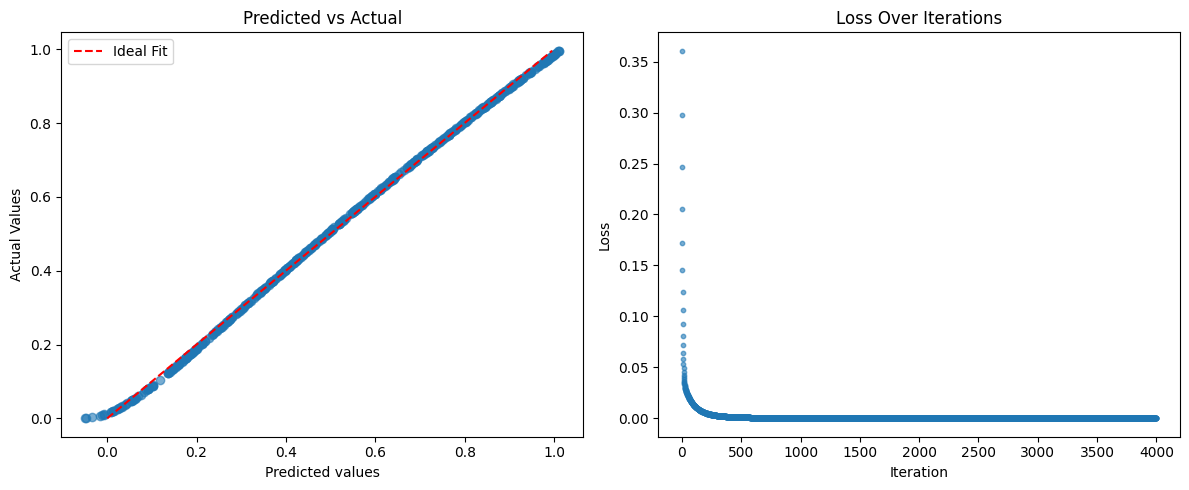

In [41]:
model = regression_model(iterations=4000, learning_rate = 1e-4)
model.fit(data=data, formula=formula)

# Results
model.summary(data)

## Ridge Regularization (L1)